In [78]:
import matplotlib.pyplot as plt
import numpy as np
import random, math, copy

In [79]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_arms = 3

# Oracle theta of each arm
theta = np.array([0.7, 0.5, 0.4])

# Problem 2: Implement classical bandit algorithms 

## 1. The epsilon-greedy Algorithm

In [80]:
def epsilon_greedy(epsilon, N, theta):
    """
    Implement the epsilon-greedy algorithm for a Bernoulli bandit problem.

    Parameters
    ----------
    epsilon : float
        The probability of exploration.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.

    Returns
    -------
    total_reward : float
        Total reward accumulated over N time steps.
    """
    Q = np.zeros(num_arms)  # Estimated values for each arm
    counts = np.zeros(num_arms)  # Count of how many times each arm is pulled
    total_reward = 0  # Total reward tracker

    # Initialization: Pull each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] = 1
        Q[arm] = reward
        total_reward += reward

    # Main loop: Epsilon-greedy exploration and exploitation
    for t in range(num_arms, N):
        if np.random.rand() < epsilon:
            # Exploration: choose a random arm
            arm = np.random.randint(num_arms)
        else:
            # Exploitation: choose the arm with the highest estimated value
            arm = np.argmax(Q)
        
        # Simulate pulling the chosen arm
        reward = 1 if np.random.rand() < theta[arm] else 0
        
        counts[arm] += 1
        Q[arm] += (1 / counts[arm]) * (reward - Q[arm])
        
        total_reward += reward
    
    return total_reward

## 2. The UCB (Upper Confidence Bound) Algorithm

In [81]:
def ucb(c, N, theta):
    """
    Implement the UCB (Upper Confidence Bound) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    c : float
        Confidence level parameter for the UCB algorithm.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """

    Q = np.zeros(num_arms)
    counts = np.zeros(num_arms)
    total_reward = 0
    
    # Initialize by pulling each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        Q[arm] = reward
        counts[arm] = 1
        total_reward += reward

    for t in range(num_arms+1, N+1):
        # Avoid division by zero because each arm was pulled once
        ucb_values = Q + c * np.sqrt((2*np.log(t))/counts)
        arm = np.argmax(ucb_values)
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] += 1
        Q[arm] += (1/counts[arm])*(reward - Q[arm])
        total_reward += reward
    return total_reward

## 3. TS (Thompson Sampling) Algorithm

In [82]:
from scipy.stats import beta

def thompson_sampling(N, theta, alpha_init, beta_init):
    """
    Implement the Thompson Sampling (TS) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    alpha_init : array-like
        Initial alpha parameters for the Beta distributions of each arm.
    beta_init : array-like
        Initial beta parameters for the Beta distributions of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """
    alpha = alpha_init.copy()
    beta_ = beta_init.copy()
    total_reward = 0
    for t in range(N):
        sampled_thetas = [np.random.beta(alpha[j], beta_[j]) for j in range(num_arms)]
        arm = np.argmax(sampled_thetas)
        reward = 1 if np.random.rand() < theta[arm] else 0
        total_reward += reward
        alpha[arm] += reward
        beta_[arm] += 1 - reward
    return total_reward


# Problem 3: Each experiment lasts for $N = 5000$ time slots, and we run each experiment $200$ trials. Results are averaged over these $200$ independent trials.

In [83]:
# Parameters
N = 5000
num_trials = 200
epsilons = [0.1, 0.5, 0.9]
cs = [1, 5, 10]

# Two sets of prior parameters for TS
# Set 1: (1,1), (1,1), (1,1)
alpha_set_1 = np.array([1, 1, 1])
beta_set_1 = np.array([1, 1, 1])

# Set 2: (601,401), (401,601), (2,3)
alpha_set_2 = np.array([601, 401, 2])
beta_set_2 = np.array([401, 601, 3])

# True parameters of the arms (as per the oracle, but not known to the algorithm)
theta = np.array([0.7, 0.5, 0.4])

In [84]:
# Epsilon-greedy
print("Epsilon-greedy results:")
for eps in epsilons:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    mean_reward = np.mean(rewards)
    print(f"Epsilon = {eps}, Average total reward over {num_trials} trials: {mean_reward}")

Epsilon-greedy results:
Epsilon = 0.1, Average total reward over 200 trials: 3408.44
Epsilon = 0.5, Average total reward over 200 trials: 3085.66
Epsilon = 0.9, Average total reward over 200 trials: 2748.215


In [85]:
# UCB
print("\nUCB results:")
for c_val in cs:
    rewards = []
    for _ in range(num_trials):
        rewards.append(ucb(c_val, N, theta))
    mean_reward = np.mean(rewards)
    print(f"c = {c_val}, Average total reward over {num_trials} trials: {mean_reward}")


UCB results:
c = 1, Average total reward over 200 trials: 3408.315
c = 5, Average total reward over 200 trials: 2979.74
c = 10, Average total reward over 200 trials: 2829.24


In [86]:
# Thompson Sampling
print("\nThompson Sampling results:")
rewards_set_1 = []
for _ in range(num_trials):
    rewards_set_1.append(thompson_sampling(N, theta, alpha_set_1, beta_set_1))
mean_set_1 = np.mean(rewards_set_1)
print(f"Set 1 Priors (1,1),(1,1),(1,1), Average total reward: {mean_set_1}")

rewards_set_2 = []
for _ in range(num_trials):
    rewards_set_2.append(thompson_sampling(N, theta, alpha_set_2, beta_set_2))
mean_set_2 = np.mean(rewards_set_2)
print(f"Set 2 Priors (601,401),(401,601),(2,3), Average total reward: {mean_set_2}")



Thompson Sampling results:
Set 1 Priors (1,1),(1,1),(1,1), Average total reward: 3480.75
Set 2 Priors (601,401),(401,601),(2,3), Average total reward: 3492.41


# Problem 4

## 4.1 Find the optimal results for each algorithm

Best epsilon: 0.03
Maximum average total reward: 3457.02


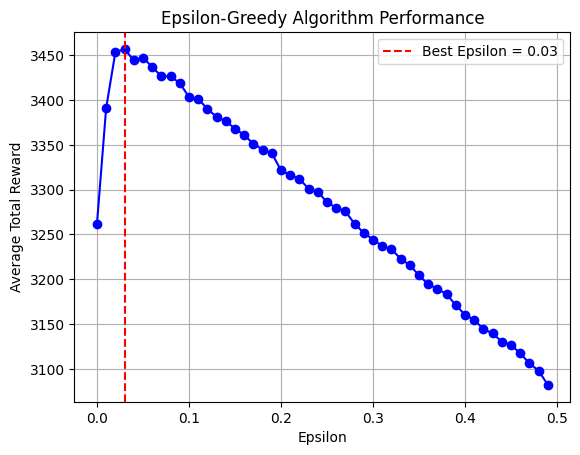

In [94]:
num_trials = 100

epsilon_values = np.arange(0, 0.5, 0.01)
average_rewards = []

for eps in epsilon_values:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    average_rewards.append(np.mean(rewards))

# Find the best epsilon
best_epsilon = epsilon_values[np.argmax(average_rewards)]
print(f"Best epsilon: {best_epsilon:.2f}")
print(f"Maximum average total reward: {np.max(average_rewards):.2f}")

# Plot the results
import matplotlib.pyplot as plt

plt.plot(epsilon_values, average_rewards, marker='o', linestyle='-', color = 'b')
plt.axvline(x=best_epsilon, color='r', linestyle='--', label=f'Best Epsilon = {best_epsilon:.2f}')
plt.xlabel('Epsilon')
plt.ylabel('Average Total Reward')
plt.title('Epsilon-Greedy Algorithm Performance')
plt.legend()
plt.grid(True)
plt.show()


Best c value: 0.40
Maximum average total reward: 3483.90


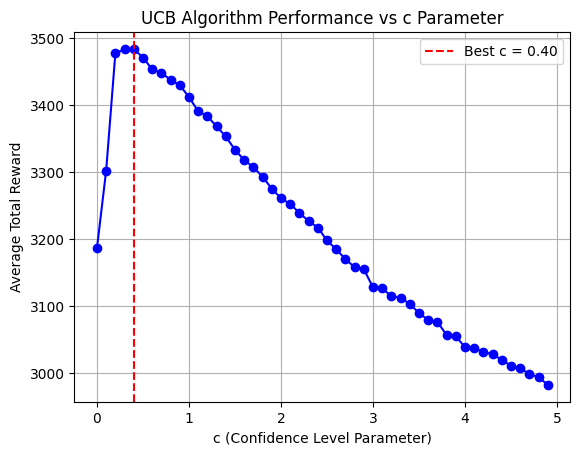

In [93]:
c_values = np.arange(0, 5, 0.1)
average_rewards = []

# Run UCB for each value of c and compute the average reward over multiple trials
for c in c_values:
    rewards = []
    for _ in range(num_trials):
        total_reward = ucb(c, N, theta)
        rewards.append(total_reward)
    average_rewards.append(np.mean(rewards))

# Identify the best c
best_c_index = np.argmax(average_rewards)
best_c = c_values[best_c_index]
best_average_reward = average_rewards[best_c_index]

print(f"Best c value: {best_c:.2f}")
print(f"Maximum average total reward: {best_average_reward:.2f}")

# Plot the results
plt.plot(c_values, average_rewards, marker='o', linestyle='-', color='b')
plt.axvline(x=best_c, color='r', linestyle='--', label=f'Best c = {best_c:.2f}')
plt.xlabel('c (Confidence Level Parameter)')
plt.ylabel('Average Total Reward')
plt.title('UCB Algorithm Performance vs c Parameter')
plt.legend()
plt.grid(True)
plt.show()